In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, amplitude_damping_error

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")


/var/folders/x6/c44jk2f54jl2th8706q9sv500000gn/T/ipykernel_4355/1607570885.py:4: DeprecationWarning: Using Qiskit with Python 3.9 is deprecated as of the 2.1.0 release. Support for running Qiskit with Python 3.9 will be removed in the 2.3.0 release, which coincides with when Python 3.9 goes end of life.
  from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister


Libraries imported successfully!


In [2]:
def get_bitflip_noise_1q(p):
    if p == 0:
        return None
    return pauli_error([("X", p), ("I", 1 - p)])

def get_depolarizing_noise_1q(p):
    if p == 0:
        return None
    return depolarizing_error(p, 1)

def get_amplitude_damping_noise_1q(p):
    if p == 0:
        return None
    return amplitude_damping_error(p)

def get_bitphaseflip_noise_1q(p):
    if p == 0:
        return None
    return pauli_error([("Y", p), ("I", 1 - p)])

def build_local_noise_model(n_qubits, p, noise_type):
    """
    Local 1-qubit noise attached to 'id' on each qubit, as in IBM's
    noise-model tutorials.[web:78][web:82][web:90]
    """
    if p == 0:
        return None

    noise_model = NoiseModel()

    if noise_type == "bitflip":
        err = get_bitflip_noise_1q(p)
    elif noise_type == "depolarizing":
        err = get_depolarizing_noise_1q(p)
    elif noise_type == "amplitude_damping":
        err = get_amplitude_damping_noise_1q(p)
    elif noise_type == "bitphaseflip":
        err = get_bitphaseflip_noise_1q(p)
    else:
        raise ValueError("Unknown noise_type")

    for q in range(n_qubits):
        noise_model.add_quantum_error(err, "id", [q])

    return noise_model

print("Local noise models defined!")


Local noise models defined!


In [3]:
def prepare_bell(qc, qr):
    # (|00> + |11>)/sqrt(2)
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])

def prepare_ghz(qc, qr):
    # (|0...0> + |1...1>)/sqrt(2)[web:80]
    n = len(qr)
    qc.h(qr[0])
    for i in range(n - 1):
        qc.cx(qr[i], qr[i + 1])

def build_prepared_state(n_qubits):
    qr = QuantumRegister(n_qubits, "q")
    cr = ClassicalRegister(n_qubits, "c")
    qc = QuantumCircuit(qr, cr)

    if n_qubits == 2:
        prepare_bell(qc, qr)
    else:
        prepare_ghz(qc, qr)
    qc.barrier(label="prep")
    return qc, qr, cr

print("Bell/GHZ preparation defined!")


Bell/GHZ preparation defined!


In [4]:
def build_standard_channel(n_qubits, n_slices):
    """
    Prepare Bell/GHZ, then apply n_slices noisy 'id' layers, then final measurement.
    The per-slice noise strength will be chosen so that total noise probability is p.[file:73]
    """
    qc, qr, cr = build_prepared_state(n_qubits)

    for _ in range(n_slices):
        for q in range(n_qubits):
            qc.id(q)

    qc.barrier(label="final readout")
    qc.measure(qr, cr)
    return qc

print("Standard multi-slice channel defined!")


Standard multi-slice channel defined!


In [5]:
def build_qze_channel(n_qubits, n_slices, n_meas):
    """
    QZE-style channel:

    - Total evolution split into n_slices noisy layers.
    - After every 'k = n_slices // n_meas' slices, measure qubit 0 in Z and
      immediately re-entangle it with the rest, preserving the Bell/GHZ structure
      while projecting out large deviations.[web:31][web:76][web:85][web:89]

    n_meas: number of intermediate Zeno measurements (excluding final readout).
    """
    if n_meas <= 0 or n_meas >= n_slices:
        raise ValueError("Require 0 < n_meas < n_slices for meaningful QZE.")

    qc, qr, cr = build_prepared_state(n_qubits)

    step_interval = n_slices // n_meas
    meas_count = 0

    for s in range(1, n_slices + 1):
        # One noisy layer
        for q in range(n_qubits):
            qc.id(q)

        # Time to perform a Zeno measurement?
        if s % step_interval == 0 and meas_count < n_meas and s != n_slices:
            meas_count += 1
            qc.barrier(label=f"Zeno meas {meas_count}")

            # Measure qubit 0 in Z to collapse back towards |0> or |1>
            qc.measure(qr[0], cr[0])

            # Reset and re-entangle from classical |0>
            qc.reset(qr[0])
            # rebuild entanglement backbone: qubit 0 -> rest
            qc.h(qr[0])
            for i in range(1, n_qubits):
                qc.cx(qr[0], qr[i])

    qc.barrier(label="final readout")
    qc.measure(qr, cr)
    return qc

print("QZE channel with periodic measurements defined!")


QZE channel with periodic measurements defined!


In [6]:
def logical_ghz_ber(counts, n_qubits):
    """
    Logical error rate for Bell/GHZ in Z basis:
    - Ideal outcomes are '0...0' and '1...1'.
    - Any other string counts as a logical error.[web:80][web:84]
    """
    total_shots = sum(counts.values())
    if total_shots == 0:
        return 0.0

    ideal0 = "0" * n_qubits
    ideal1 = "1" * n_qubits
    good = counts.get(ideal0, 0) + counts.get(ideal1, 0)
    return 1.0 - good / total_shots

print("Logical BER metric defined!")


Logical BER metric defined!


In [7]:
def run_multiqubit_qze_experiment(
    n_qubits_list,
    p_noise=0.25,
    n_slices=10,
    n_meas_qze=5,
    shots=4000,
):
    """
    For each n and each noise type:
      - Standard: n_slices layers with per-slice noise p_slice = p_noise / n_slices.
      - QZE: same slicing, but with n_meas_qze Zeno measurements of qubit 0.
    """
    noise_types = ["bitflip", "depolarizing", "amplitude_damping", "bitphaseflip"]

    results_standard = {n: {} for n in n_qubits_list}
    results_qze = {n: {} for n in n_qubits_list}

    for n in n_qubits_list:
        print(f"=== n = {n} qubits ===")
        for nt in noise_types:
            print(f"  Noise: {nt}")

            # per-slice noise so total ~ p_noise after n_slices
            p_slice = p_noise / n_slices
            noise_model = build_local_noise_model(n, p_slice, nt)
            simulator = AerSimulator(noise_model=noise_model)

            # Standard
            qc_std = build_standard_channel(n, n_slices)
            job_std = simulator.run(qc_std, shots=shots)
            counts_std = job_std.result().get_counts()
            ber_std = logical_ghz_ber(counts_std, n)
            results_standard[n][nt] = ber_std

            # QZE
            qc_qze = build_qze_channel(n, n_slices, n_meas_qze)
            job_qze = simulator.run(qc_qze, shots=shots)
            counts_qze = job_qze.result().get_counts()
            ber_qze = logical_ghz_ber(counts_qze, n)
            results_qze[n][nt] = ber_qze

            print(f"    Standard BER: {ber_std:.4f}, QZE BER: {ber_qze:.4f}")

    return results_standard, results_qze

print("Experiment driver defined!")


Experiment driver defined!


In [12]:
n_qubits_list = [2, 3, 4]  # Bell for 2, GHZ for 3 and 4
p_noise = 0.25
n_slices = 15        # total channel segments
n_meas_qze = 10      # number of intermediate Zeno measurements (<= n_slices-1)
shots = 8000         # increase for smoother statistics

results_std, results_qze = run_multiqubit_qze_experiment(
    n_qubits_list,
    p_noise=p_noise,
    n_slices=n_slices,
    n_meas_qze=n_meas_qze,
    shots=shots,
)

print("Experiment completed.")


=== n = 2 qubits ===
  Noise: bitflip
    Standard BER: 0.3231, QZE BER: 0.4928
  Noise: depolarizing
    Standard BER: 0.1977, QZE BER: 0.4926
  Noise: amplitude_damping
    Standard BER: 0.1714, QZE BER: 0.4928
  Noise: bitphaseflip
    Standard BER: 0.3154, QZE BER: 0.5026
=== n = 3 qubits ===
  Noise: bitflip
    Standard BER: 0.4890, QZE BER: 0.6607
  Noise: depolarizing
    Standard BER: 0.3034, QZE BER: 0.6010
  Noise: amplitude_damping
    Standard BER: 0.2588, QZE BER: 0.5875
  Noise: bitphaseflip
    Standard BER: 0.4906, QZE BER: 0.6595
=== n = 4 qubits ===
  Noise: bitflip
    Standard BER: 0.5924, QZE BER: 0.7361
  Noise: depolarizing
    Standard BER: 0.3786, QZE BER: 0.6476
  Noise: amplitude_damping
    Standard BER: 0.3150, QZE BER: 0.6398
  Noise: bitphaseflip
    Standard BER: 0.5902, QZE BER: 0.7418
Experiment completed.


In [13]:
noise_types = ["bitflip", "depolarizing", "amplitude_damping", "bitphaseflip"]

print(f"Logical BER for Bell (2q) and GHZ (3,4q) at p = {p_noise}, n_slices = {n_slices}, N_Zeno = {n_meas_qze}")
print("| n qubits | Noise type        | Standard BER | QZE BER | Improvement (%) |")
print("|----------|-------------------|--------------|---------|-----------------|")

for n in n_qubits_list:
    for nt in noise_types:
        ber_std = results_std[n][nt]
        ber_qze = results_qze[n][nt]
        if ber_std == 0:
            imp = 0.0
        else:
            imp = 100.0 * (ber_std - ber_qze) / ber_std
        print(f"| {n:8d} | {nt:17s} | {ber_std:12.4f} | {ber_qze:7.4f} | {imp:13.1f} |")


Logical BER for Bell (2q) and GHZ (3,4q) at p = 0.25, n_slices = 15, N_Zeno = 10
| n qubits | Noise type        | Standard BER | QZE BER | Improvement (%) |
|----------|-------------------|--------------|---------|-----------------|
|        2 | bitflip           |       0.3231 |  0.4928 |         -52.5 |
|        2 | depolarizing      |       0.1977 |  0.4926 |        -149.1 |
|        2 | amplitude_damping |       0.1714 |  0.4928 |        -187.5 |
|        2 | bitphaseflip      |       0.3154 |  0.5026 |         -59.4 |
|        3 | bitflip           |       0.4890 |  0.6607 |         -35.1 |
|        3 | depolarizing      |       0.3034 |  0.6010 |         -98.1 |
|        3 | amplitude_damping |       0.2588 |  0.5875 |        -127.1 |
|        3 | bitphaseflip      |       0.4906 |  0.6595 |         -34.4 |
|        4 | bitflip           |       0.5924 |  0.7361 |         -24.3 |
|        4 | depolarizing      |       0.3786 |  0.6476 |         -71.0 |
|        4 | amplitude_damp

In [14]:
def sweep_qze_parameters(
    n_qubits,
    p_values,
    n_slices_values,
    n_meas_values,
    shots=4000,
):
    """
    Sweep over noise probability p, number of slices, and number of Zeno measurements.

    For each (p, n_slices, n_meas):
      - Set per-slice noise p_slice = p / n_slices
      - Build local noise model
      - Simulate Standard and QZE channels
      - Compute logical Bell/GHZ BER and % improvement

    Returns:
      results[(p, n_slices, n_meas)] = {
          "ber_std": ...,
          "ber_qze": ...,
          "improvement": ...   # in percent
      }
    """
    noise_types = ["bitflip", "depolarizing", "amplitude_damping", "bitphaseflip"]

    results = {}

    for p in p_values:
        for n_slices in n_slices_values:
            p_slice = p / n_slices
            for n_meas in n_meas_values:
                if not (0 < n_meas < n_slices):
                    continue

                print(f"n={n_qubits}, p={p:.2f}, slices={n_slices}, N_Zeno={n_meas}")
                results[(p, n_slices, n_meas)] = {}

                for nt in noise_types:
                    # build noise per slice
                    noise_model = build_local_noise_model(n_qubits, p_slice, nt)
                    simulator = AerSimulator(noise_model=noise_model)

                    # Standard
                    qc_std = build_standard_channel(n_qubits, n_slices)
                    job_std = simulator.run(qc_std, shots=shots)
                    counts_std = job_std.result().get_counts()
                    ber_std = logical_ghz_ber(counts_std, n_qubits)

                    # QZE
                    qc_qze = build_qze_channel(n_qubits, n_slices, n_meas)
                    job_qze = simulator.run(qc_qze, shots=shots)
                    counts_qze = job_qze.result().get_counts()
                    ber_qze = logical_ghz_ber(counts_qze, n_qubits)

                    if ber_std == 0:
                        improvement = 0.0
                    else:
                        improvement = 100.0 * (ber_std - ber_qze) / ber_std

                    results[(p, n_slices, n_meas)][nt] = {
                        "ber_std": ber_std,
                        "ber_qze": ber_qze,
                        "improvement": improvement,
                    }

    return results


In [15]:
# Parameter grids (you can adjust)
p_values = [0.10, 0.20, 0.25, 0.30, 0.40]
n_slices_values = [4, 6, 8, 10, 12]
n_meas_values = [1, 2, 3, 4, 5]

shots_sweep = 3000  # reduce a bit to keep runtime reasonable

sweep_results = {}

for n_qubits in [2, 3, 4]:
    print(f"\n========== Sweeping for n = {n_qubits} qubits ==========")
    sweep_results[n_qubits] = sweep_qze_parameters(
        n_qubits,
        p_values=p_values,
        n_slices_values=n_slices_values,
        n_meas_values=n_meas_values,
        shots=shots_sweep,
    )

print("Full sweep finished.")



========== Sweeping for n = 2 qubits ==========
n=2, p=0.10, slices=4, N_Zeno=1
n=2, p=0.10, slices=4, N_Zeno=2
n=2, p=0.10, slices=4, N_Zeno=3
n=2, p=0.10, slices=6, N_Zeno=1
n=2, p=0.10, slices=6, N_Zeno=2
n=2, p=0.10, slices=6, N_Zeno=3
n=2, p=0.10, slices=6, N_Zeno=4
n=2, p=0.10, slices=6, N_Zeno=5
n=2, p=0.10, slices=8, N_Zeno=1
n=2, p=0.10, slices=8, N_Zeno=2
n=2, p=0.10, slices=8, N_Zeno=3
n=2, p=0.10, slices=8, N_Zeno=4
n=2, p=0.10, slices=8, N_Zeno=5
n=2, p=0.10, slices=10, N_Zeno=1
n=2, p=0.10, slices=10, N_Zeno=2
n=2, p=0.10, slices=10, N_Zeno=3
n=2, p=0.10, slices=10, N_Zeno=4
n=2, p=0.10, slices=10, N_Zeno=5
n=2, p=0.10, slices=12, N_Zeno=1
n=2, p=0.10, slices=12, N_Zeno=2
n=2, p=0.10, slices=12, N_Zeno=3
n=2, p=0.10, slices=12, N_Zeno=4
n=2, p=0.10, slices=12, N_Zeno=5
n=2, p=0.20, slices=4, N_Zeno=1
n=2, p=0.20, slices=4, N_Zeno=2
n=2, p=0.20, slices=4, N_Zeno=3
n=2, p=0.20, slices=6, N_Zeno=1
n=2, p=0.20, slices=6, N_Zeno=2
n=2, p=0.20, slices=6, N_Zeno=3
n=2, p=0.20, 

In [16]:
noise_types = ["bitflip", "depolarizing", "amplitude_damping", "bitphaseflip"]

for n_qubits in [2, 3, 4]:
    print(f"\n=== Best and worst QZE improvement for n = {n_qubits} ===")
    res = sweep_results[n_qubits]

    for nt in noise_types:
        best = None
        worst = None

        for (p, n_slices, n_meas), vals in res.items():
            if nt not in vals:
                continue
            imp = vals[nt]["improvement"]

            if best is None or imp > best["improvement"]:
                best = {
                    "p": p,
                    "n_slices": n_slices,
                    "n_meas": n_meas,
                    "improvement": imp,
                    "ber_std": vals[nt]["ber_std"],
                    "ber_qze": vals[nt]["ber_qze"],
                }
            if worst is None or imp < worst["improvement"]:
                worst = {
                    "p": p,
                    "n_slices": n_slices,
                    "n_meas": n_meas,
                    "improvement": imp,
                    "ber_std": vals[nt]["ber_std"],
                    "ber_qze": vals[nt]["ber_qze"],
                }

        print(f"\nNoise type: {nt}")
        if best is not None:
            print("  Best improvement:")
            print(f"    p = {best['p']:.2f}, slices = {best['n_slices']}, N_Zeno = {best['n_meas']}")
            print(f"    BER_std = {best['ber_std']:.4f}, BER_qze = {best['ber_qze']:.4f}")
            print(f"    Improvement = {best['improvement']:.1f}%")
        if worst is not None:
            print("  Worst (most negative) improvement:")
            print(f"    p = {worst['p']:.2f}, slices = {worst['n_slices']}, N_Zeno = {worst['n_meas']}")
            print(f"    BER_std = {worst['ber_std']:.4f}, BER_qze = {worst['ber_qze']:.4f}")
            print(f"    Improvement = {worst['improvement']:.1f}%")



=== Best and worst QZE improvement for n = 2 ===

Noise type: bitflip
  Best improvement:
    p = 0.10, slices = 4, N_Zeno = 1
    BER_std = 0.1777, BER_qze = 0.1633
    Improvement = 8.1%
  Worst (most negative) improvement:
    p = 0.10, slices = 10, N_Zeno = 2
    BER_std = 0.1580, BER_qze = 0.5023
    Improvement = -217.9%

Noise type: depolarizing
  Best improvement:
    p = 0.40, slices = 12, N_Zeno = 1
    BER_std = 0.2913, BER_qze = 0.2690
    Improvement = 7.7%
  Worst (most negative) improvement:
    p = 0.10, slices = 6, N_Zeno = 5
    BER_std = 0.0790, BER_qze = 0.4957
    Improvement = -527.4%

Noise type: amplitude_damping
  Best improvement:
    p = 0.10, slices = 10, N_Zeno = 1
    BER_std = 0.0857, BER_qze = 0.0740
    Improvement = 13.6%
  Worst (most negative) improvement:
    p = 0.10, slices = 8, N_Zeno = 5
    BER_std = 0.0757, BER_qze = 0.4887
    Improvement = -545.8%

Noise type: bitphaseflip
  Best improvement:
    p = 0.20, slices = 12, N_Zeno = 1
    BER_st

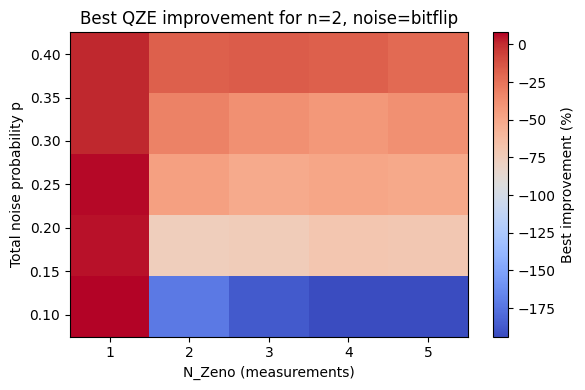

In [17]:
def heatmap_for_noise(n_qubits, noise_type, p_values, n_meas_values):
    """
    For a fixed n_qubits and noise_type, build an (len(p_values) x len(n_meas_values))
    matrix of max improvement over all n_slices, then plot as a heatmap.
    """
    import matplotlib.pyplot as plt

    res = sweep_results[n_qubits]
    data = np.zeros((len(p_values), len(n_meas_values)))

    for i, p in enumerate(p_values):
        for j, n_meas in enumerate(n_meas_values):
            best_imp = None
            for n_slices in n_slices_values:
                key = (p, n_slices, n_meas)
                if key not in res:
                    continue
                if noise_type not in res[key]:
                    continue
                imp = res[key][noise_type]["improvement"]
                if best_imp is None or imp > best_imp:
                    best_imp = imp
            data[i, j] = best_imp if best_imp is not None else 0.0

    plt.figure(figsize=(6,4))
    im = plt.imshow(data, origin="lower", aspect="auto",
                    extent=[min(n_meas_values)-0.5, max(n_meas_values)+0.5,
                            min(p_values)-0.025, max(p_values)+0.025],
                    cmap="coolwarm")
    plt.colorbar(im, label="Best improvement (%)")
    plt.xlabel("N_Zeno (measurements)")
    plt.ylabel("Total noise probability p")
    plt.title(f"Best QZE improvement for n={n_qubits}, noise={noise_type}")
    plt.tight_layout()
    plt.show()

# Example: visualize bit-flip behaviour for n=2
heatmap_for_noise(2, "bitflip", p_values, n_meas_values)
